# *Optical Tweezers* | Lab-Session #8
## Feb-22-2021 14:42

This jupyter notebook is a used to collect and analyse data from Monday, Feb 22nd.

## TO DO
- ~~add voltage - position conversion for different laser powers~~
- more accurate fitting of PSD? (good enough for now)
- propagate errors
- ~~do analysis for equipartition theorem~~

In [67]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as const
from scipy import interpolate
import scipy.signal
import os
from csvlib import *
from scipy.optimize import curve_fit
from IPython.display import display
from PIL import Image
from tqdm import tqdm

# Display mpl in notebook format
%matplotlib inline

In [125]:
# save data to csv

coord = ['x','y']
import csv

for i in range(2):
    with open('free_bead_data_'+coord[i]+'.csv', mode='w') as free_bead_data:
        initiate = csv.writer(free_bead_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        initiate.writerow(['Laser Intensity (mA)', 'k_equipartition', 'k_eq_err','trap_boltz','PSD_I_k','PSD_II_drag',
                           'PSD_II_k_b','PSD_II_f0','PSD_II_k','PSD_III_f0','PSD_III_k','PSD_III_drag'])
    

# Data Collection

Data were collected for the calibration of the optical trap, by trapping a bead and plotting the power spectrum of each coordinate.

In [118]:
# open CSV files to numpy array
csvs = list_csv(PRINT='True')   # Lists CSV files in a given directory

# 0 - 2: laser power 100
# 3 - 6: laser power 150
# 7 - 8: laser power 200
# 9 - 10: laser power 250
# 11: laser power 300

indx = 1                        # Index of data file in the list


DATA = pd.read_csv(csvs[indx])  # Gets the CSV file as a Pandas Data Frame

data = DATA.to_numpy().T        # Gets data as a numpy array
DATA                            # Prints pretty PANDAS data frame



# DATA                            # Prints pretty PANDAS data frame

# which data?

#100--- 1
#150--- 6
#200--- 8
#250--- 10
#300--- 11


# importing QPD calibration data

# from LAB 7
CAL_X = pd.read_csv('cal-stg-qpd-x.txt',skip_blank_lines=True,comment='#')
CAL_Y = pd.read_csv('cal-stg-qpd-y.txt',skip_blank_lines=True,comment='#')

# calibration for V_stage as a function of V_qpd

cal_x_alpha = CAL_X.to_numpy().T[0]
err_x_alpha = CAL_X.to_numpy().T[1]

cal_alpha = np.array([CAL_X.to_numpy().T[0],CAL_Y.to_numpy().T[0]])
err_alpha = np.array([CAL_X.to_numpy().T[1],CAL_Y.to_numpy().T[1]])

laser_intensity = CAL_X.to_numpy().T[2].tolist()

# from LAB 6
cal_beta = np.array([1.746e-06,1.776e-06])
err_beta = np.array([0.009e-06,0.047e-06])

#cal_QPD = np.array([np.repeat(0,len(laser_intensity)),np.repeat(0,len(laser_intensity))])
#err_QPD = np.array([np.repeat(0,len(laser_intensity)),np.repeat(0,len(laser_intensity))])

# construct calibration arrays
cal_QPD = []
err_QPD = []

for i in range(2):
    cal_QPD.append(cal_alpha[i]*cal_beta[i])
    err_QPD.append(err_alpha[i]*err_beta[i])


# note
# cal_QPD[i][j]: i is coordinate, j is laser intensity

# for this file

laser = float(csvs[indx].split('_')[2][:3])
laser_indx = list.index(laser_intensity,laser)

print(cal_QPD)
print (err_QPD)

k_boltz = []
PSD_I_k = []

PSD_II_drag = []
PSD_II_k_b = []
PSD_II_f0 = []
PSD_II_k = []

PSD_III_f0 = []
PSD_III_k = []
PSD_III_drag = []

List of .csv files in .
	 0 : TRP_free_100 #1.csv
	 1 : TRP_free_100 #2.csv
	 2 : TRP_free_100.csv
	 3 : TRP_free_150 #1.csv
	 4 : TRP_free_150 #2.csv
	 5 : TRP_free_150 #3.csv
	 6 : TRP_free_150.csv
	 7 : TRP_free_200 #1.csv
	 8 : TRP_free_200.csv
	 9 : TRP_free_250 #1.csv
	 10 : TRP_free_250.csv
	 11 : TRP_free_300.csv
	 12 : free_bead_data.csv
	 13 : free_bead_data_x.csv
[array([-2.7796320e-07, -1.4755446e-07, -9.7950600e-08, -7.8430320e-08,
       -6.3973440e-08]), array([-3.081360e-07, -1.721832e-07, -8.910192e-08, -6.940608e-08,
       -5.942496e-08])]
[array([1.8810e-11, 8.8839e-12, 7.2666e-12, 4.5909e-12, 4.5000e-12]), array([8.91120e-11, 4.88330e-11, 3.37836e-11, 1.84240e-11, 1.27652e-11])]


# Data Analysis

### Power spectrum and Boltzmann's distribution analysis
Plotting time series from QPD output. Calculating PSD and fitting. Calclating potential energy from Boltzmann's distribution and fitting.

QPD voltage in x and y directions is converted to position values using the conversion factors generated in LAB 7.

Data set under consideration: TRP_free_100 #2.csv

Here is an image from the trap
Theoretical drag coefficient  1.6776104770169493e-08


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


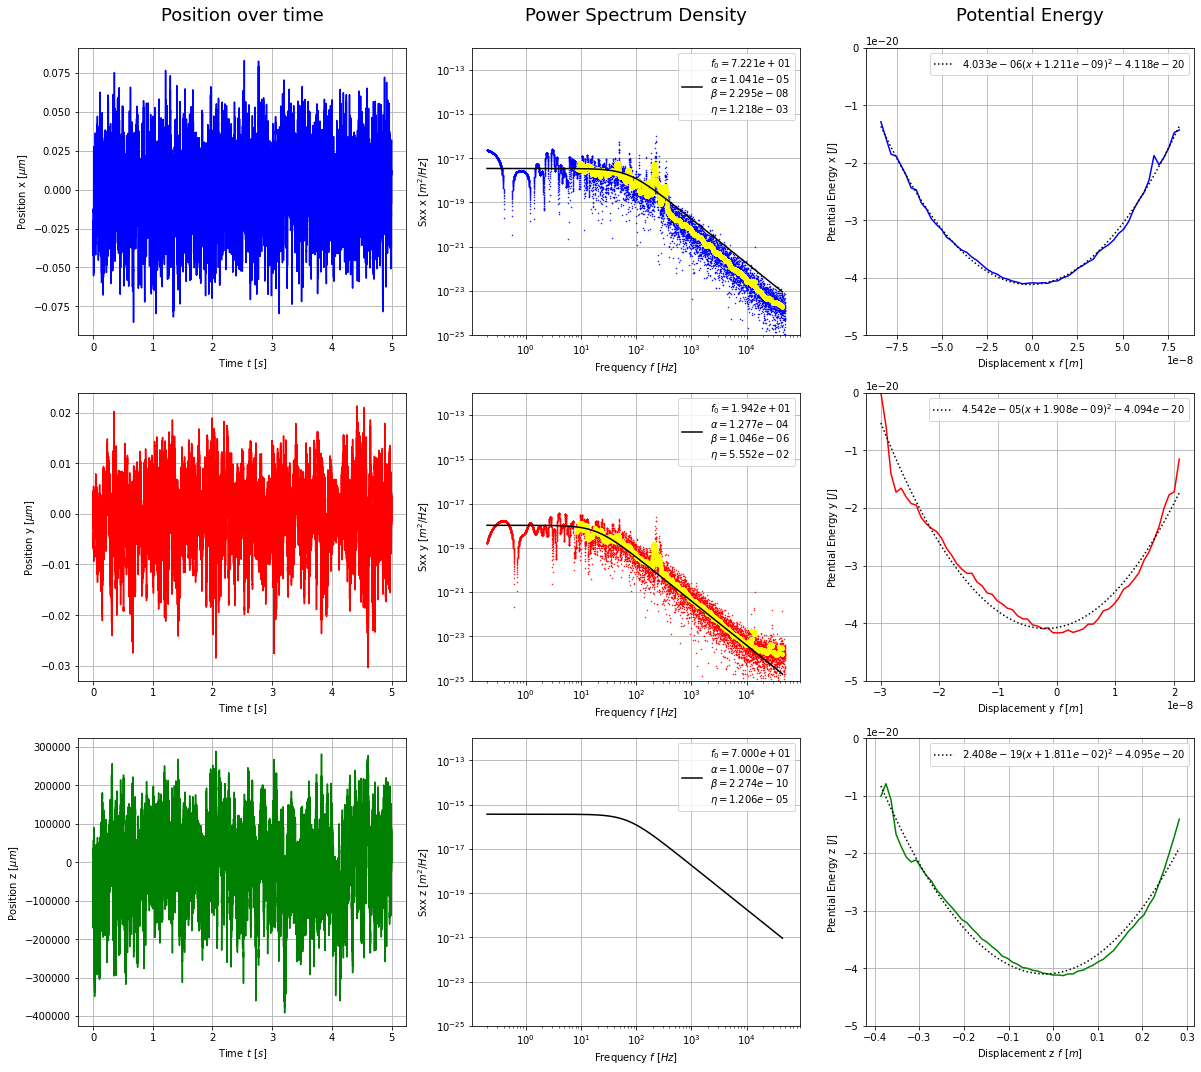

In [127]:
########################################### Getting data from file

## Store the different variables
t = np.linspace(0,5,500000)

# centering data around 0
x = data[0]-sum(data[0])/len(data[0])
y = data[1]-sum(data[1])/len(data[1])
z = data[2]-sum(data[2])/len(data[2])

# converting QPD voltage to position of stage

x_pos = x*cal_QPD[0][laser_indx]
y_pos = y*cal_QPD[1][laser_indx]

########################################### IMG and INFO

# Print Data frame information
print("Data set under consideration: "+csvs[indx])      # Print filename
#trp = csvs[indx].split('_')[0]                          # Get trap number
#print("The trap attempt is: "+trp)                      # Print trap number
print("\nHere is an image from the trap")
img = Image.open("TRP_free.tif")
scale = 0.5
img = img.resize((int(img.size[0]*scale),int(img.size[1]*scale)))

#display(img)


########################################### FIT FUNCTIONS

# constants
eta = 8.9e-4 #2.414e-5
d   = 2e-6
T = 294.15
beta = 3*np.pi*eta*d

print("Theoretical drag coefficient ", beta)

# to fit PSD
SxxI = lambda f,alpha: (const.k*T)/(np.pi**2 * beta*(f**2 + (alpha/(2*np.pi*beta))**2))
SxxII = lambda f,f_0,alpha: alpha/(f**2+f_0**2)
SxxIII = lambda f,f_0,alpha: (2*const.k*T*f_0)/(np.pi*alpha*(f**2+f_0**2))

##### Description of functions
# Sxx: assumes theoretical drag coefficient; one fit parameter - trap stiffness
# SxxII: two fit parameters - the cutoff frequency and drag coefficient;
#        can calculate Boltzmann's constant experimentally by assuming theoretical drag
# SxxIII: two fit parameters - cutoff frequency and trap stiffness

# to fit energy
poly = lambda x,a,b,c: a*(x+b)**2+c

# to calculate PSD
fs = ((max(t)-min(t))/len(t))**(-1)        # sampling frequency of data collection
Nbins = 60                                 # binning of position data to get energy histogram


###########################################  Creating FIGURE
fig = plt.figure(figsize=(20,18))

coords = [x_pos,y_pos,z]
labels = ['x','y','z']
colors = ['b','r','g']

#data to store


for i in tqdm(range(0,3)):
    
    ####################################### plotting POSITION
    # Adding the necessary plot elements
    ax = fig.add_subplot(331+i*3)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [\mu m]$')
    ax.grid()
    
    ax.plot(t,coords[i]*1e6,c=colors[i])

    
    ###################################### plotting POWER SPECTRUM DENSITY
    # Adding the necessary plot elements
    ax = fig.add_subplot(332+i*3)
    if i==0: ax.set_title('Power Spectrum Density\n',fontsize=18)
    ax.set_xlabel(r'Frequency $f\ [Hz]$')
    ax.set_ylabel('Sxx ' + labels[i] + r' $ [m^2/Hz]$')
    ax.grid()

    # Obtaining the power spectrum
    f,pxx = scipy.signal.periodogram(coords[i],fs=fs,scaling='density')
    
    # rescaling the data (to be equally distributed in log x)
    sample_size = 10000
    
    spl = interpolate.splrep(f, pxx)
    f_new = np.exp(np.linspace(np.log(f[1]), np.log(f[-1]), sample_size))
    pxx_new = interpolate.splev(f_new, spl)
    
    #moving average
    total = len(pxx_new)
    window = int(sample_size/100)
    
    pxx_avg = np.zeros(total-window)
    
    for k in range (total-window):
        pxx_avg[k] = np.sum(pxx_new[k:k+window])/window
    
    f_avg = f_new[:total-window]
    
    #section to fit
    start = int(0.3*sample_size)
    end = int(0.99*sample_size)
    
    # Plot the power spectrum
    ax.plot(f_new,pxx_new,'.',c=colors[i],ms=1)
    
    #cut1 = int(0.55*sample_size)
    #cut2 = int(0.65*sample_size)
    
    #f_cut = np.concatenate((f_avg[start:cut1], f_avg[cut2:end]),axis=None)
    #pxx_cut = np.concatenate((pxx_avg[start:cut1], pxx_avg[cut2:end]))
    
    # region to be fitted
    f_fit = f_avg[start:end]
    pxx_fit = pxx_avg[start:end]
    #f_fit = f_cut
    #pxx_fit = pxx_cut
    
    ax.plot(f_fit,pxx_fit,'.',c='yellow')
    
    
    ###################################### fitting POWER SPECTRUM DENSITY 
    
    method = 'III'
    
    if method == 'I':
        alpha_trap = 1e-7
        params, _ = curve_fit(SxxI,f_fit,pxx_fit,p0=[alpha_trap])
        
        PSD_I_k.append(params[0])
        #assumes theoretical drag
        
        # Plot the fit
        ax.plot(f_avg,SxxI(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0]/(2*np.pi*beta))+
                '\n'+r'$\alpha = %1.3e$'%(params[0]))
    
    if method == 'II':
        A_0 = 1e8*(const.k*T/(np.pi**2*3*np.pi*eta*d))
        #f_0 = 1e-14/(2*np.pi**2*3*eta*d)
        f_0 = 1e2 
        
        params, _ = curve_fit(SxxII,f_fit,pxx_fit,p0=[f_0,A_0])
        
        k_b = params[1]*(np.pi**2*3*np.pi*eta*d)/T
        
        beta_fit = const.k*T/(np.pi**2*params[1])
        
        PSD_II_drag.append(beta_fit)
        PSD_II_k_b.append(k_b)
        PSD_II_f0.append(params[0])
        PSD_II_k.append(params[0]*(2*np.pi**2*3*eta*d))
        
        print("drag coefficient from fit", beta_fit)
        
        # Plot the fit
        ax.plot(f_avg,SxxII(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0])+
                        '\n'+r'$\alpha = %1.3e$'%(params[0]*(2*np.pi**2*3*eta*d))+
                        '\n'+r'$K_b = %1.3e$'%k_b+
                        '\n'+r'$\beta = %1.3e$'%beta_fit)
        
    if method == 'III':
        
        f_0 = 70
        alpha_trap = 1e-7
        
        params, _ = curve_fit(SxxIII,f_fit,pxx_fit,p0=[f_0,alpha_trap])

        PSD_III_f0.append(params[0])
        PSD_III_k.append(params[1])
        PSD_III_drag.append(params[1]/(2*np.pi*params[0]))
        
        # Plot the fit
        ax.plot(f_avg,SxxIII(f_avg,*params),c='k',\
                label=r'$f_0 = %1.3e$'%(params[0])+
                '\n'+r'$\alpha = %1.3e$'%(params[1])+
                '\n'+r'$\beta = %1.3e$'%(params[1]/(2*np.pi*params[0]))+
                '\n'+r'$\eta = %1.3e$'%((params[1]/(2*np.pi*params[0]))/(3*d*np.pi)))
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-25,1e-12)
    ax.legend()

    ###################################### plotting POTENTIAL ENERGY
    
    # Adding the necessary plot elements
    ax = fig.add_subplot(333+i*3)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [m]$')
    ax.set_ylabel('Ptential Energy ' + labels[i] + r' $ [J]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = np.array([(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)])
    
    # Finding energy
    E = -const.k*T*np.log(hist)

    # Plot the potential energy
    ax.plot(xx,E,c=colors[i])
    
    # Obtaining the best fit curve for the histogram
    #params = np.polyfit(xx,E, 2)
    params, _ = curve_fit(poly,xx,E,p0=[1e-5,1e-10,1e-20])
    ax.plot(xx,poly(xx,*params),ls=':',c='k',
            label=r'$ %1.3e (x + %1.3e)^2  % 1.3e  $'%tuple(params)) 
    k_boltz.append(params[0])
    ax.set_ylim(-0.5e-19,0)
    ax.legend()

plt.show()

Data set under consideration: TRP_free_100 #2.csv

Here is an image from the trap


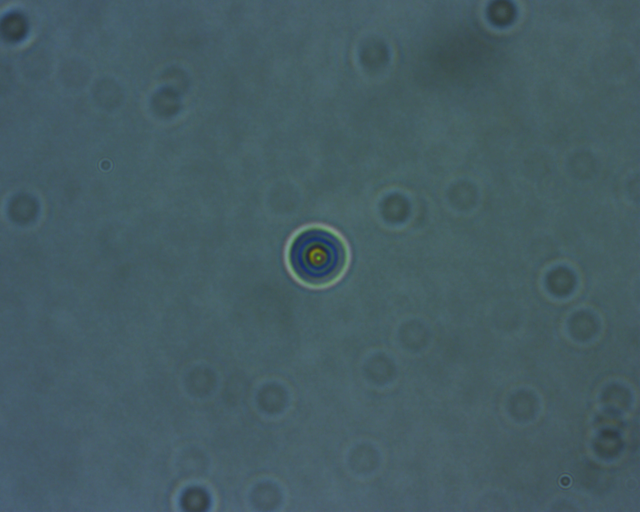

In [116]:
# NOT UPDATED

# Print Data frame information

print("Data set under consideration: "+csvs[indx])      # Print filename
#trp = csvs[indx].split('_')[0]                          # Get trap number
#print("The trap attempt is: "+trp)                      # Print trap number
print("\nHere is an image from the trap")
img = Image.open("TRP_free.tif")
scale = 0.5
img = img.resize((int(img.size[0]*scale),int(img.size[1]*scale)))
display(img)


In [98]:
# NOT UPDATED

%%script echo skipping 
# Plotting X-Y-Z
# Set up figure
fig = plt.figure(figsize=(16,18))

coords = [x,y,z]
labels = ['x','y','z']

for i in range(0,3):
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    ax.grid()

    ax.plot(t,coords[i],c='C%d'%(i+7))


UsageError: Line magic function `%%script` not found.


# Potential Energy

Now we will plot the potential energy of each of those thingys

In [ ]:
# NOT UPDATED

%%script echo skipping 
# Potential energy
# Function to attempt to fit the power spectrum with
fig = plt.figure(figsize=(16,18))

# Calculate the power spectrum 
coords = [x,y,z]
labels = ['x','y','z']
Nbins = 100

for i in range(0,len(coords)):
    # Adding the necessary plot elements
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [V]$')
    ax.set_ylabel('V' + labels[i] + r' $ [AU]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = [(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)]

    # Plot the potential energy
    ax.plot(xx,-np.log(hist),c='C%d'%(i+7))
    # ax.legend()

# Data Analysis

### Using equipartition theorem 

Plotting time series from QPD output. Calculating the variance of the time series and fitting with equipartition theorem.

QPD voltage in x and y directions is converted to position values using the conversion factors generated in LAB 7 AND 6.

Variance of  x  is  5.188515369111294e-16
Variance of  y  is  4.126768542756938e-17
Variance of  z  is  0.008270686794493711


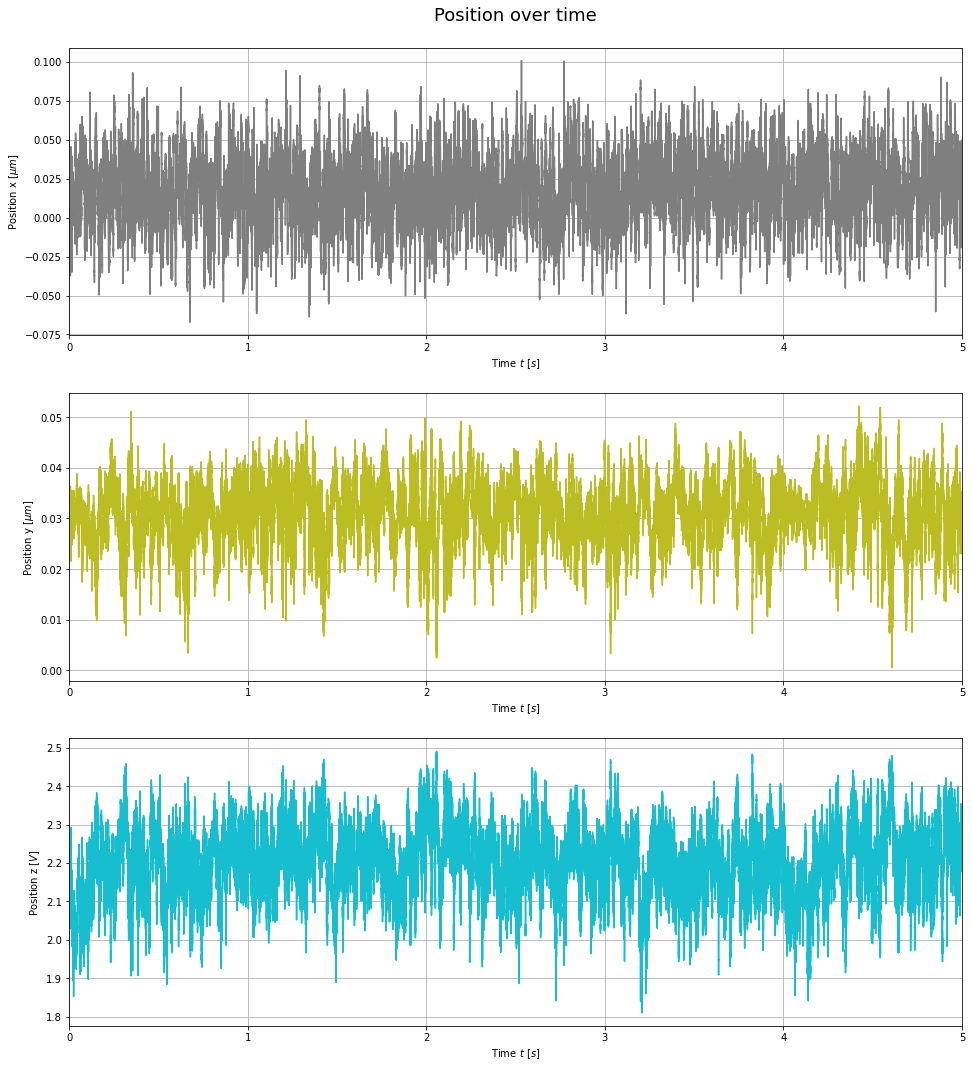

In [112]:
############ getting data

x = data[0]
y = data[1]
z = data[2]

# converting to position for x and y

x_pos = x*cal_QPD[0][laser_indx]
y_pos = y*cal_QPD[1][laser_indx]

# Set up figure
fig = plt.figure(figsize=(16,18))

unit = [1e6,1e6,1] # plot position in um

coords = [x_pos,y_pos,z]
labels = ['x','y','z']

for i in range(len(coords)):
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [\mu m]$')
    
    if i > 1:
        ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    
    ax.grid()

    ax.plot(t,coords[i]*unit[i],c='C%d'%(i+7))
    ax.set_xlim(0,5)

# calculating variance 

# find average; for each point calculate (x-avg)^2; sum it up

variance= []

for i in range (len(coords)):
    avg = sum(coords[i])/len(coords[i])
    var = sum((coords[i]-avg)**2)/len(coords[i])
    print("Variance of ",labels[i]," is ",var)
    
    variance.append(var) 
    
    

var_i = np.array(variance)

k_equi = const.k*T/var_i

# finding errors

err_k_equi = []
for i in range(2):
    err_k_equi.append( 2*k_equi[i]*np.sqrt((err_alpha[i][laser_indx]/cal_alpha[i][[laser_indx]])**2 + 
                                           (err_beta[i]/cal_beta[i])**2) )

In [126]:

labels = ['x','y','z']

for i in range(2):
    with open('free_bead_data_'+labels[i]+'.csv', mode='a') as free_bead_data_x:
        save_data = csv.writer(free_bead_data_x, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        save_data.writerow([laser,k_equi[i],err_k_equi[i],k_boltz[i],PSD_I_k[i],PSD_II_drag[i],
                           PSD_II_k_b[i],PSD_II_f0[i],PSD_II_k[i],PSD_III_f0[i],PSD_III_k[i], PSD_III_drag[i]])
        
        

In [113]:
print (k_equi)
print (err_k_equi)

[7.82724680e-06 9.84106327e-05 4.91032865e-19]
[array([2.20788518e-07]), array([5.63528384e-06])]


In [90]:
9/25

0.36